# Money Management: Stock Price Forecasting Using Neural Sequence Translation

Neural Sequence Translation (NST) is an tweak version of Recurrent Neural Network which not just forecasts a point in the future but an entire vector in the future. Just like [Neural Machine Translation](https://arxiv.org/abs/1409.0473), this notebook explores this upgrade philosophy and apply this idea in a singular stock data.

Stock price today is probably dependent on:
- The trend it has been folloing from the previous day.
- The price it was traded at from previous day.
- Some other factors that may affect stock price today.

Generalize intuition from above to the following:
- The previous cell state (i.e. the information that was present in the memory after the previous time step).
- The previous hidden state (i.e. this is the same as the output of the previous cell).
- The input at the current time step (i.e. the new information that is being fed in at that moment).

In this notebook, we cover
- Part 1 - Data Preprocessing
- Part 2 - Construct NST Architecture
- Part 3 - Predictions and Performance Visualization

A Production of [Yin's Capital](www.YinsCapital.com)

## Recurrent Neural Network (a sequential model)

Given data $X$ and $Y$, we want to feed information forward into a time stamp. Then we form some belief and we make some initial predictions. We investigate our beliefs by looking at the loss function of the initial guesses and the real value. We update our model according to error we observed. 

## Architecture: Feed-forward

Consider data with time stamp
$$X_{\langle 1 \rangle} \rightarrow X_{\langle 2 \rangle} \rightarrow \dots \rightarrow X_{\langle T \rangle}$$
and feed-forward architecture pass information through exactly as the following:
$$
\text{Information in:} \rightarrow
\begin{matrix}
Y_{\langle 1 \rangle}, \{\hat{Y}_{\langle 1 \rangle}, ..., \hat{Y}_{\langle k \rangle}\} & Y_{\langle 2 \rangle}, \{\hat{Y}_{\langle 1 \rangle}, ..., \hat{Y}_{\langle k \rangle}\} &       & Y_{\langle T \rangle}, \{\hat{Y}_{\langle 1 \rangle}, ..., \hat{Y}_{\langle k \rangle}\} \\
\uparrow               & \uparrow               &       & \uparrow \\
X_{\langle 1 \rangle} \rightarrow    & X_{\langle 2 \rangle} \rightarrow    & \dots \rightarrow & X_{\langle T \rangle} \\
\uparrow               & \uparrow               &       & \uparrow \\
w_{\langle 1 \rangle}, b_{0, \langle 1 \rangle}    & w_{\langle 2 \rangle}, b_{0, \langle 2 \rangle}    &       & w_{\langle T \rangle}, b_{0, \langle T \rangle} \\
\end{matrix}
\rightarrow
\text{Form beliefs about } Y_{\langle T \rangle}
$$
while the educated guesses $\hat{Y}_{\langle T \rangle}$ are our beliefs about real $Y$ at time stamp $T$. 

## Architecture: Feed-backward

Let us clearly define our loss function to make sure we have a proper grip of our mistakes. 
$$\mathcal{L} = \sum_t \sum_k L(\hat{y}_{\langle t,k \rangle} - y_{\langle t,k \rangle})^2$$
and we can compute the gradient 
$$\triangledown = \frac{\partial \mathcal{L}}{\partial a}$$
and then with respect with parameters $w$ and $b$
$$\frac{\partial \triangledown}{\partial w}, \frac{\partial \triangledown}{\partial a}$$
and now with perspective of where we make our mistakes according to our parameters we can go backward
$$
\text{Information in:} \leftarrow
\underbrace{
\begin{matrix}
Y_{\langle 1 \rangle}, \{\hat{Y}_{\langle 1 \rangle}, ..., \hat{Y}_{\langle k \rangle}\} & Y_{\langle 2 \rangle}, \{\hat{Y}_{\langle 1 \rangle}, ..., \hat{Y}_{\langle k \rangle}\} &       & Y_{\langle T \rangle}, \{\hat{Y}_{\langle 1 \rangle}, ..., \hat{Y}_{\langle k \rangle}\} \\
\uparrow               & \uparrow               &       & \uparrow \\
X_{\langle 1 \rangle} \leftarrow    & X_{\langle 2 \rangle} \leftarrow    & \dots \leftarrow & X_{\langle T \rangle} \\
\uparrow               & \uparrow               &       & \uparrow \\
w'_{\langle 1 \rangle}, b'_{0, \langle 1 \rangle}    & w'_{\langle 2 \rangle}, b'_{0, \langle 2 \rangle}    &       & w'_{\langle T \rangle}, b'_{0, \langle T \rangle} \\
\end{matrix}}_{\text{Update: } w, b \text{ with } w', b'}
\leftarrow
\text{Total Loss: } \mathcal{L} (\hat{y}, y)
$$
and the *update* action in the above architecture is dependent on your optimizer specified in the algorithm.

## Part 1: Data Processing

In [1]:
# libraries
import pandas as pd
import numpy as np
import yfinance as yf

In [259]:
# set parameters
start_date       =   '2013-01-01'
end_date         =   '2019-12-6'
ticker           =   'AAPL'
w                =   1
h                =   5
cutoff           =   0.8
numOfHiddenLayer =   3
l1_units         =   50
l2_units         =   50
l2_units         =   50
l3_units         =   50
l4_units         =   30
l5_units         =   10
dropOutRate       =  0.2
optimizer        =   'adam'
loss             =   'mean_squared_error'
useDice          =   True
epochs           =   50
batch_size       =   64
plotGraph        =   True
verbose          =   True

In [142]:
# get data
stockData = yf.download(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


We make the following simple assumptions:
- the explanatory data matrix $X$ is the downloaded stock data except the first row
- the response data matrix $Y$ is the downloaded stock data except the last row
- this way we are using stock data at $t$ to predict stock data at $t+1$
- the information in the response data matrix $Y$: open, high, low, close, adjusted close

In [277]:
stockData = stockData.iloc[:,:5]

In [278]:
stockData.head(2)

,Open,High,Low,Close,Adj Close
Date,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.985447
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.771053


In [279]:
Y = stockData.iloc[1::, ]
X = stockData.iloc[0:1744,]

In [280]:
X_train = X.iloc[0:round(X.shape[0]*cutoff), ]
X_test = X.iloc[round(X.shape[0]*cutoff):X.shape[0], ]

In [281]:
y_train = Y.iloc[0:round(Y.shape[0]*cutoff), ]
y_test = Y.iloc[round(Y.shape[0]*cutoff):Y.shape[0], ]

In [282]:
X_train = np.array(X_train).reshape(X_train.shape[0], w, h)
X_test = np.array(X_test).reshape(X_test.shape[0], w, h)

In [283]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1395, 1, 5)
(349, 1, 5)
(1395, 5)
(349, 5)


## Part 2: Design a Neural Sequence Translation Architecture

In [284]:
### Build RNN
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import time

# Initialize RNN
begintime = time.time()
regressor = Sequential()

In [285]:
# Design hidden layers
if numOfHiddenLayer == 2:
    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l1_units, return_sequences = True, input_shape = (w, h)))
    regressor.add(Dropout(dropOutRate))

    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l2_units))
    regressor.add(Dropout(dropOutRate))

elif numOfHiddenLayer == 3:
    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l1_units, return_sequences = True, input_shape = (w, h)))
    regressor.add(Dropout(dropOutRate))

    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l2_units, return_sequences = True))
    regressor.add(Dropout(dropOutRate))

    # Adding a third LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l3_units))
    regressor.add(Dropout(dropOutRate))

elif numOfHiddenLayer == 4:
    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l1_units, return_sequences = True, input_shape = (w, h)))
    regressor.add(Dropout(dropOutRate))

    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l2_units, return_sequences = True))
    regressor.add(Dropout(dropOutRate))

    # Adding a third LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l3_units, return_sequences = True))
    regressor.add(Dropout(dropOutRate))

    # Adding a fourth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l4_units))
    regressor.add(Dropout(dropOutRate))

elif numOfHiddenLayer == 5:
    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l1_units, return_sequences = True, input_shape = (w, h)))
    regressor.add(Dropout(dropOutRate))

    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l2_units, return_sequences = True))
    regressor.add(Dropout(dropOutRate))

    # Adding a third LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l3_units, return_sequences = True))
    regressor.add(Dropout(dropOutRate))

    # Adding a fourth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l4_units, return_sequences = True))
    regressor.add(Dropout(dropOutRate))

    # Adding a fifth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l5_units))
    regressor.add(Dropout(dropOutRate))

In [286]:
# Adding the output layer
regressor.add(Dense(units = y_train.shape[1]))
endtime = time.time()

In [287]:
# Summary
if verbose:
    print("--------------------------------------------")
    print('Let us investigate the sequential models.')
    regressor.summary()
    print("--------------------------------------------")
    print("Time Consumption (in sec):", endtime - begintime)
    print("Time Consumption (in min):", round((endtime - begintime)/60, 2))
    print("Time Consumption (in hr):", round((endtime - begintime)/60)/60, 2)
    print("--------------------------------------------")

--------------------------------------------
Let us investigate the sequential models.
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 1, 50)             11200     
_________________________________________________________________
dropout_24 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 1, 50)             20200     
_________________________________________________________________
dropout_25 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_26 (Dropout)         (None, 50)                0         
________________________________

In [288]:
### Train RNN
# Compiling the RNN
start = time.time()
regressor.compile(optimizer = optimizer, loss = loss)

In [289]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)
end = time.time()

Epoch 1/50
22/22 [==============================] - 0s 3ms/step - loss: 862.6714
Epoch 2/50
22/22 [==============================] - 0s 3ms/step - loss: 827.0408
Epoch 3/50
22/22 [==============================] - 0s 3ms/step - loss: 700.5491
Epoch 4/50
22/22 [==============================] - 0s 3ms/step - loss: 580.1807
Epoch 5/50
22/22 [==============================] - 0s 3ms/step - loss: 508.9561
Epoch 6/50
22/22 [==============================] - 0s 3ms/step - loss: 459.9046
Epoch 7/50
22/22 [==============================] - 0s 2ms/step - loss: 417.4770
Epoch 8/50
22/22 [==============================] - 0s 3ms/step - loss: 383.0302
Epoch 9/50
22/22 [==============================] - 0s 2ms/step - loss: 353.6742
Epoch 10/50
22/22 [==============================] - 0s 2ms/step - loss: 325.6520
Epoch 11/50
22/22 [==============================] - 0s 2ms/step - loss: 298.9647
Epoch 12/50
22/22 [==============================] - 0s 2ms/step - loss: 277.4525
Epoch 13/50
22/22 [======

In [272]:
# Time Check
if verbose == True: 
    print('Time Consumption:', end - start)

Time Consumption: 6.635748624801636


## Part 3: Predictions and Performance Visualization

In [273]:
### Predictions
predicted_stock_price = regressor.predict(X_test)

In [274]:
real_stock_price = y_test

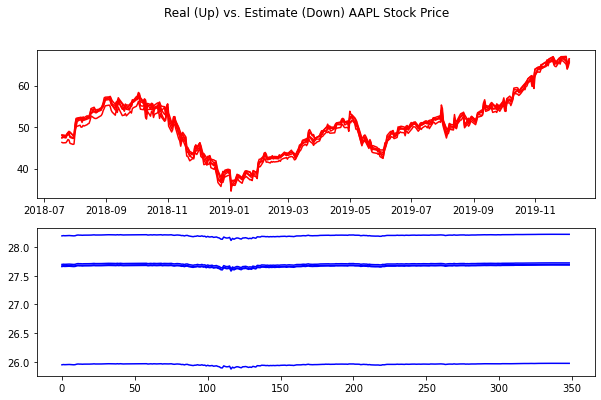

In [275]:
# Visualising the results
import matplotlib.pyplot as plt
if plotGraph:
    fig, axs = plt.subplots(2, figsize = (10,6))
    fig.suptitle(f'Real (Up) vs. Estimate (Down) {tickers} Stock Price')
    axs[0].plot(real_stock_price, color = 'red', label = f'Real {tickers[0]} Stock Price')
    axs[1].plot(predicted_stock_price, color = 'blue', label = f'Predicted {tickers[0]} Stock Price')